In [451]:
import numpy as np

import pandas as pd

import kagglehub

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN,KMeans,AgglomerativeClustering

from sklearn.neighbors import NearestNeighbors

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, davies_bouldin_score

1️⃣ Load and Explore Dataset

In [452]:

# Define the dataset path
dataset_path = "/Users/Dataghost/.cache/kagglehub/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/versions/1/Mall_Customers.csv"

# Load the dataset
df = pd.read_csv(dataset_path, encoding="ISO-8859-1")

# Display the first few rows
print(df.head())


   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


✅ Dataset Features:

CustomerID → Unique ID for each customer
Gender → Male / Female
Age → Age of the customer
Annual Income (k$) → Income of the customer in thousands of dollars
Spending Score (1-100) → Score assigned based on spending behavior

2️⃣ Data Preprocessing

Select Features for Clustering

In [453]:
# Selecting only numerical features

X = df[['Annual Income (k$)','Spending Score (1-100)']]

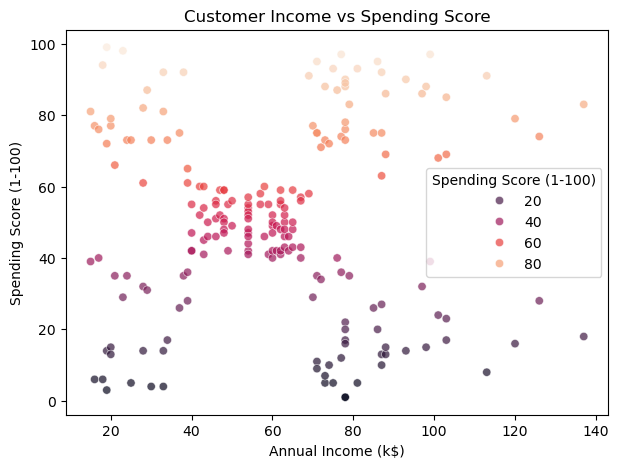

In [454]:
# Visualizing data distribution

plt.figure(figsize=(7,5))

sns.scatterplot(x=df['Annual Income (k$)'],
                y=df['Spending Score (1-100)'], 
                hue=df['Spending Score (1-100)'],  # Color by spending score
                palette="rocket",
                alpha=0.7)

# sns.color_palette("ch:s=-.2,r=.6")  # Modern stylish palette

plt.xlabel("Annual Income (k$)")

plt.ylabel("Spending Score (1-100)")

plt.title("Customer Income vs Spending Score")

plt.show()


✅ Why only these features?

Annual Income and Spending Score directly impact customer segmentation.
Gender & Age are categorical, and we focus on numerical clustering.

3️⃣ K-Means Clustering

Find Optimal Clusters using Elbow Method

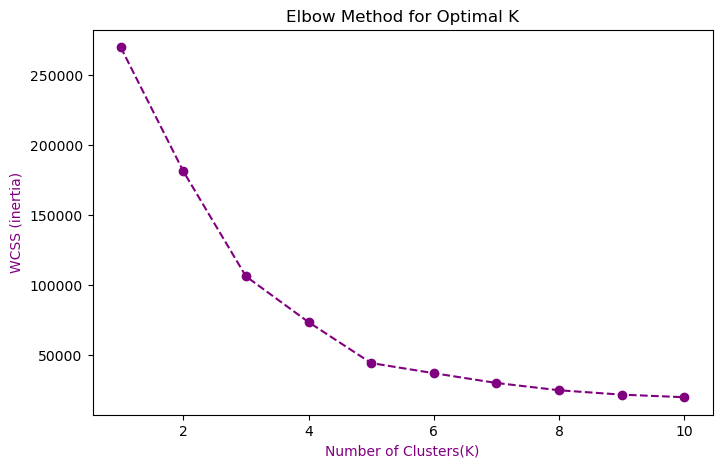

In [455]:
# Find optimal k using the elbow method

wcss = [] # Within-cluster sum of squares

for k in  range(1,11):

    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10 )

    kmeans.fit(X)

    wcss.append(kmeans.inertia_)


# Plot Elbow Curve

plt.figure(figsize=(8,5))

plt.plot(range(1,11), wcss, marker='o', linestyle='--', color='purple')

plt.xlabel('Number of Clusters(K)',color='purple')

plt.ylabel("WCSS (inertia)", color='purple')

plt.title('Elbow Method for Optimal K')

plt.show()

✅ Choose k = 5 (Optimal point where WCSS stops decreasing significantly)

Apply K-Means Clustering

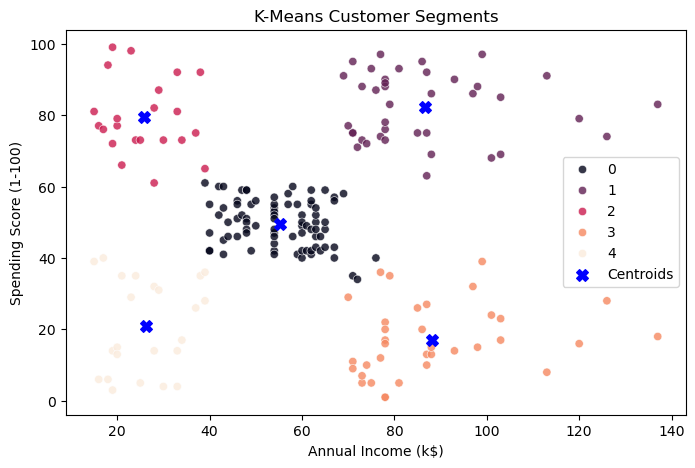

In [456]:
# Apply K-Means with k=5

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)

df['Cluster_KMeans'] = kmeans.fit_predict(X)

# Visualize Clusters

plt.figure(figsize=(8,5))

sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], hue=df['Cluster_KMeans'], palette="rocket", alpha=0.8)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=70, c='BLUE', marker='X', label="Centroids")

plt.xlabel("Annual Income (k$)")

plt.ylabel("Spending Score (1-100)")

plt.title("K-Means Customer Segments")

plt.legend()

plt.show()



4️⃣ DBSCAN Clustering

Find Optimal ε (Epsilon)

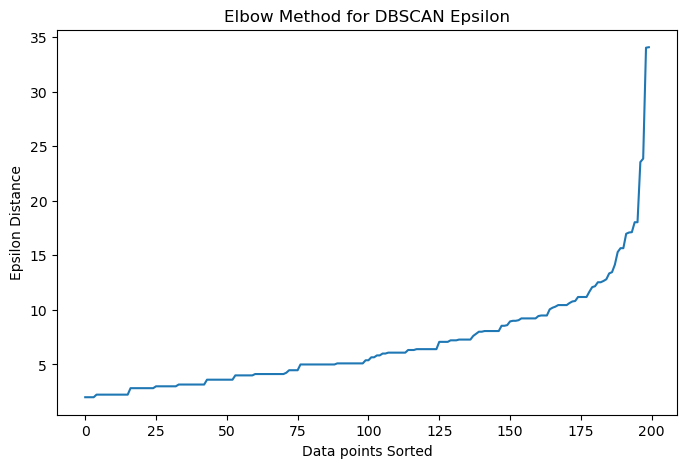

In [457]:
# Find optimal epsilon using k-distance plot

neighbors = NearestNeighbors(n_neighbors=5)

neighbors_fit = neighbors.fit(X)

distances, indices = neighbors_fit.kneighbors(X)

# Sort distances and plot

distances = np.sort(distances[:,4], axis=0)

plt.figure(figsize=(8,5))

plt.plot(distances)

plt.xlabel("Data points Sorted")

plt.ylabel('Epsilon Distance')

plt.title('Elbow Method for DBSCAN Epsilon')

plt.show()

✅ Choose ε = 8 (based on elbow point of k-distance plot)

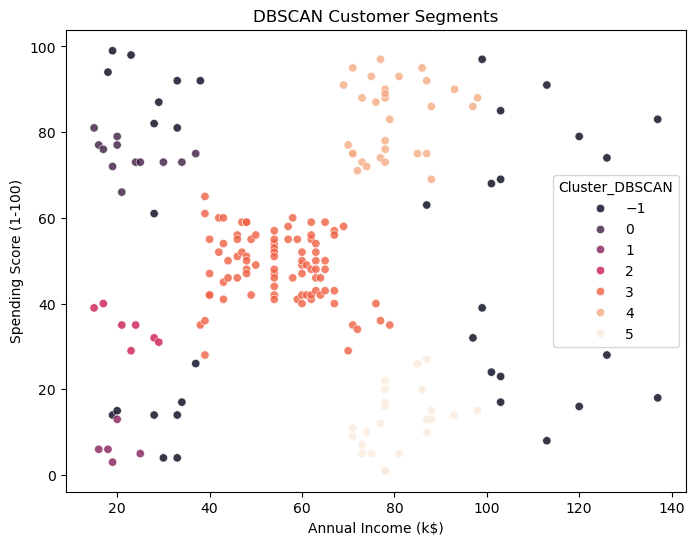

In [458]:
# Apply DBSCAN with optimal ε and min_samples

dbscan = DBSCAN(eps=8, min_samples=5)

df['Cluster_DBSCAN']= dbscan.fit_predict(X)

# Visualize DBSCAN Clusters

plt.figure(figsize=(8,6))

sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], hue=df['Cluster_DBSCAN'], palette="rocket", alpha=0.8)

plt.xlabel("Annual Income (k$)")

plt.ylabel("Spending Score (1-100)")

plt.title("DBSCAN Customer Segments")

plt.show()


✅ Interpretation:

DBSCAN identifies outliers (label = -1)
Noise points are left unclustered

 5️⃣ Hierarchical Clustering

Apply Hierarchical Clustering

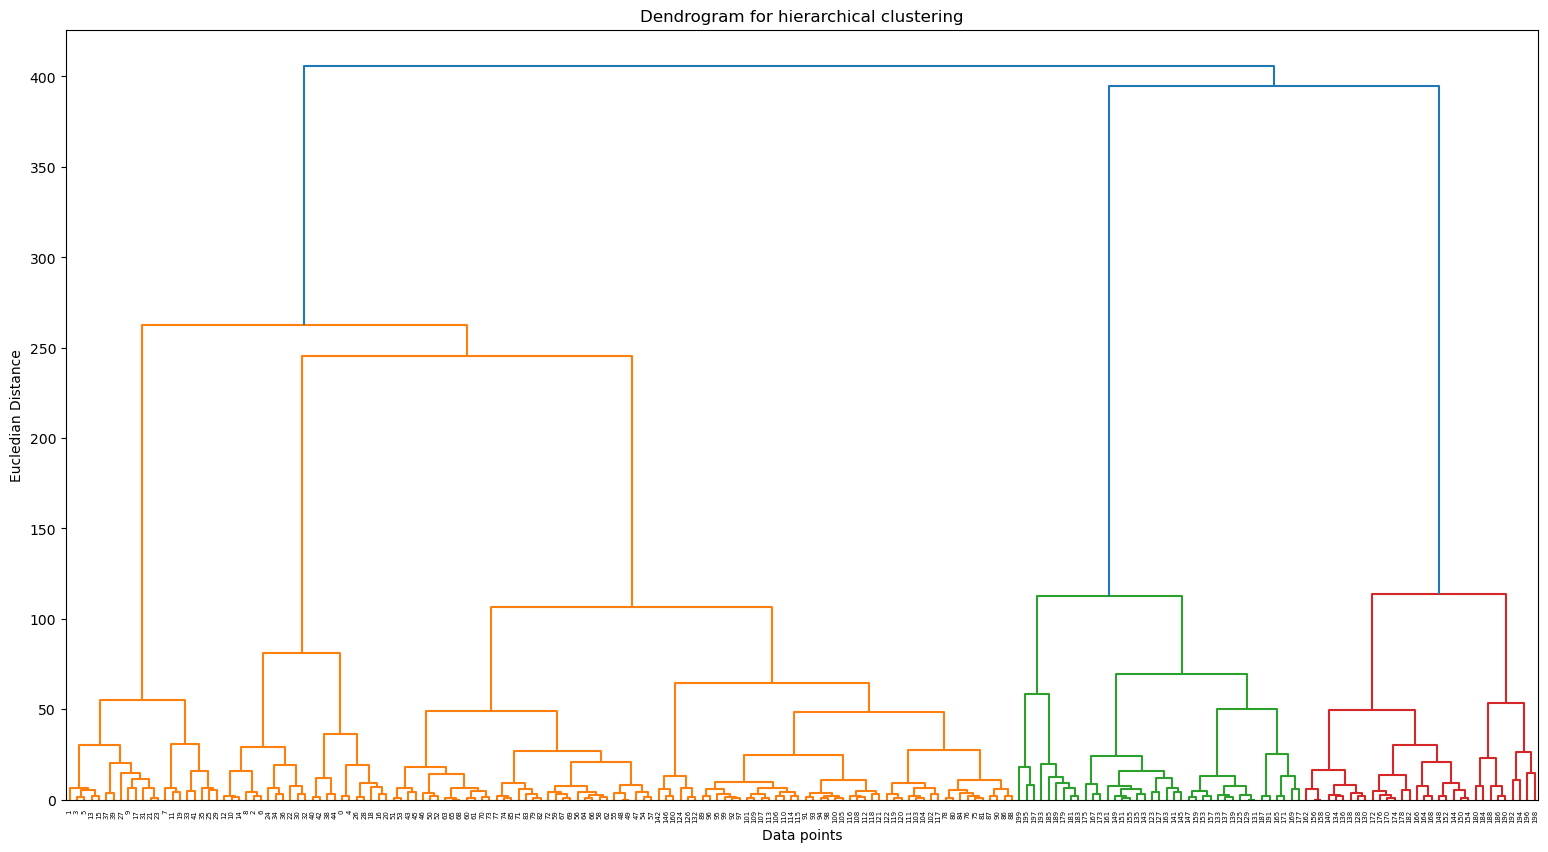

In [459]:
# Create linkage matrix

linkage_matrix = linkage(X,method='ward')

# Plot Dendrogram

plt.figure(figsize=(19,10))

dendrogram(linkage_matrix)

plt.title('Dendrogram for hierarchical clustering')

plt.xlabel('Data points')

plt.ylabel('Eucledian Distance')

plt.show()

✅ Choose number of clusters based on dendrogram split

5️⃣ Apply Agglomerative Clustering

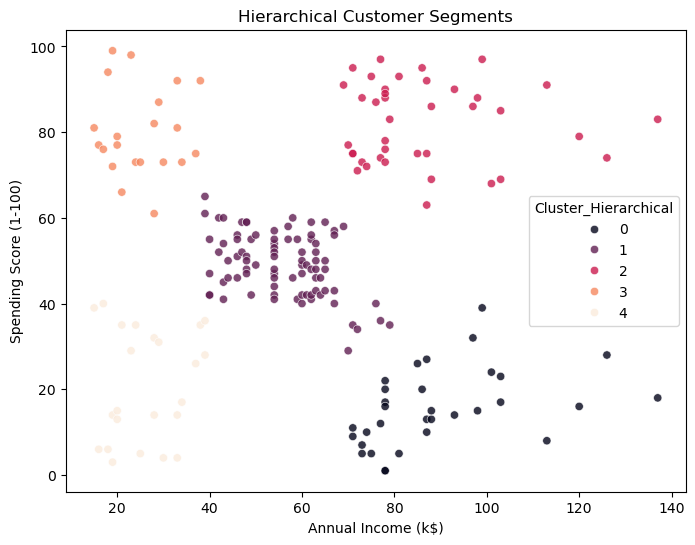

In [460]:
# Apply Hierarchical Clustering

agglo = AgglomerativeClustering(n_clusters=5)

df['Cluster_Hierarchical'] = agglo.fit_predict(X)

# Visualize Clusters

plt.figure(figsize=(8,6))

sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], hue=df['Cluster_Hierarchical'], palette="rocket", alpha=0.8)

plt.xlabel("Annual Income (k$)")

plt.ylabel("Spending Score (1-100)")

plt.title("Hierarchical Customer Segments")

plt.show()

 6️⃣ Comparing All Models

In [461]:
# Compute silhouette scores

silhouette_scores = {

    "KMeans": silhouette_score(X, df['Cluster_KMeans']),

    "DBSCAN": silhouette_score(X, df['Cluster_DBSCAN']) if len(set(df['Cluster_DBSCAN'])) > 1 else -1,

    "Hierarchical": silhouette_score(X, df['Cluster_Hierarchical'])
}

# Compute Davies-Bouldin Index

db_scores = {

    "KMeans": davies_bouldin_score(X, df['Cluster_KMeans']),

    "DBSCAN": davies_bouldin_score(X, df['Cluster_DBSCAN']) if len(set(df['Cluster_DBSCAN'])) > 1 else -1,

    "Hierarchical": davies_bouldin_score(X, df['Cluster_Hierarchical'])
}

# Print results

print("Silhouette Scores:\n" + "\n".join([f"{key}: {value}" for key, value in silhouette_scores.items()]))

print("\n" + "Davies-Bouldin Score:\n" + "\n".join([f"{key}: {value}" for key, value in db_scores.items()]))




Silhouette Scores:
KMeans: 0.553931997444648
DBSCAN: 0.3550982050619174
Hierarchical: 0.5529945955148897

Davies-Bouldin Score:
KMeans: 0.5725628995597085
DBSCAN: 2.1144643573882758
Hierarchical: 0.5782207452369451


✅ Which clustering performed best?

Higher Silhouette Score = Better cluster separation
Lower Davies-Bouldin Index = Better clustering

1️⃣ K-Means → Best for balanced, spherical clusters
2️⃣ DBSCAN → Detects anomalies and irregular clusters
3️⃣ Hierarchical → Good for hierarchical relationships